### Residual Block
![res](https://images.velog.io/images/junyoung9696/post/3137e50c-b52f-4cdd-8ae8-2faf497efe84/r10.png)

$$ F(x) + x $$
- 경사 소실 문제 해결의 핵심 요소
- $y - \hat y = y - (F(x) + x)$ → 0 으로 학습
- 즉 $F(x) → (y-x)$ : 실제 값에서 입력값을 뺀 값을 학습한다. (잔차 학습)

![lesnet](https://songminkee.github.io/studyblog/assets/picture/resnet_fig1.jpg)
- 층이 깊어질 수록 loss 값이 큰데 이는 과적합 의 문제가 아니라, 경사 소실 문제이다.
    - 과적합 이었으면 val_loss 값의 상승을 보여야 한다.

### Skip Connection (입력값 을 출력에 더하여 전달) 의 효과

- 경사 소실 완화
    - 기울기 소실 이더라도 Skip Connection 의 효과로, 유지 된다.
- 학습의 용이성
    - 입력을 출력에 전달하여 더 간단히 학습
- 모델 성능 향상
    - 최소 이전 층 성능 보다 좋음

### ResNet 모델 학습 과정

- 기본 모델 : 목표에 최대한 가깝게 예측
- 잔차 모델 : 목표와 얼마나 먼지 예측 (예측 과 목표가 일치하는 데 필요한 잔차 (Residual) 학습)

In [5]:
### ResNet
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, Flatten, Dense
from tensorflow.keras.models import Model


In [6]:
# 잔여 블록
def residual_block(x, filters, kernel_size=3):
    y = Conv2D(filters, kernel_size, padding='same')(x) # 입력 텐서 x에 대해 필터 수와 커널 크기를 지정한 컨볼루션 연산 수행
    y = BatchNormalization()(y) # 배치 정규화 -> 학습 안정화
    y = ReLU()(y)               # ReLU 활성화 함수 -> 비선형성
    y = Conv2D(filters, kernel_size, padding='same')(y) #  첫 번째 컨볼루션의 출력을 입력으로 받아 다시 컨볼루션 연산 수행
    y = BatchNormalization()(y)

    # 스킵 연결
    out = Add()([x, y])  # 입력 텐서 x와 두 번째 컨볼루션의 출력 y를 더함
    out = ReLU()(out)
    return out

# ResNet 모델 정의
def resnet(input_shape):
    input_tensor = Input(shape=input_shape)  # 입력 데이터의 형태 정의
    x = Conv2D(64, (3, 3), padding='same')(input_tensor) # 64 필터 갯수
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 잔차 블록 추가
    x = residual_block(x, 64) # 64: 필터 갯수
        # 잔차 블록 안... 두 개의 Conv2D 레이어와 BatchNormalization, ReLU를 거친 후,
        # 입력 x와 더해져 스킵 연결을 통해 최종 출력 out 생성
        # 최종 출력 out을 또 다른 잔차 블록으로 전달
    x = residual_block(x, 64) # x : Conv2D, BatchNormalization, ReLU를 거친 출력 텐서
        # 두개의 잔차 블록 더 복잡한 패턴을 학습, 기울기 소실 문제 완화


    # 출력층
    x = Flatten()(x) # 2D feature map을 1D 벡터로 변환
    x = Dense(10, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=x)  # 입력과 출력을 지정하여 모델 정의
    return model

# 모델 생성
model_resnet = resnet((32, 32, 3))
model_resnet.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     36,928 │ re_lu_5[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │     36,928 │ re_lu_6[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 32, 32,    │          0 │ re_lu_5[0][0],    │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 32, 32,    │          0 │ add_2[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     36,928 │ re_lu_7[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │     36,928 │ re_lu_8[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 32, 32,    │          0 │ re_lu_7[0][0],  

 Total params: 806,154 (3.08 MB)

 Trainable params: 805,514 (3.07 MB)

 Non-trainable params: 640 (2.50 KB)

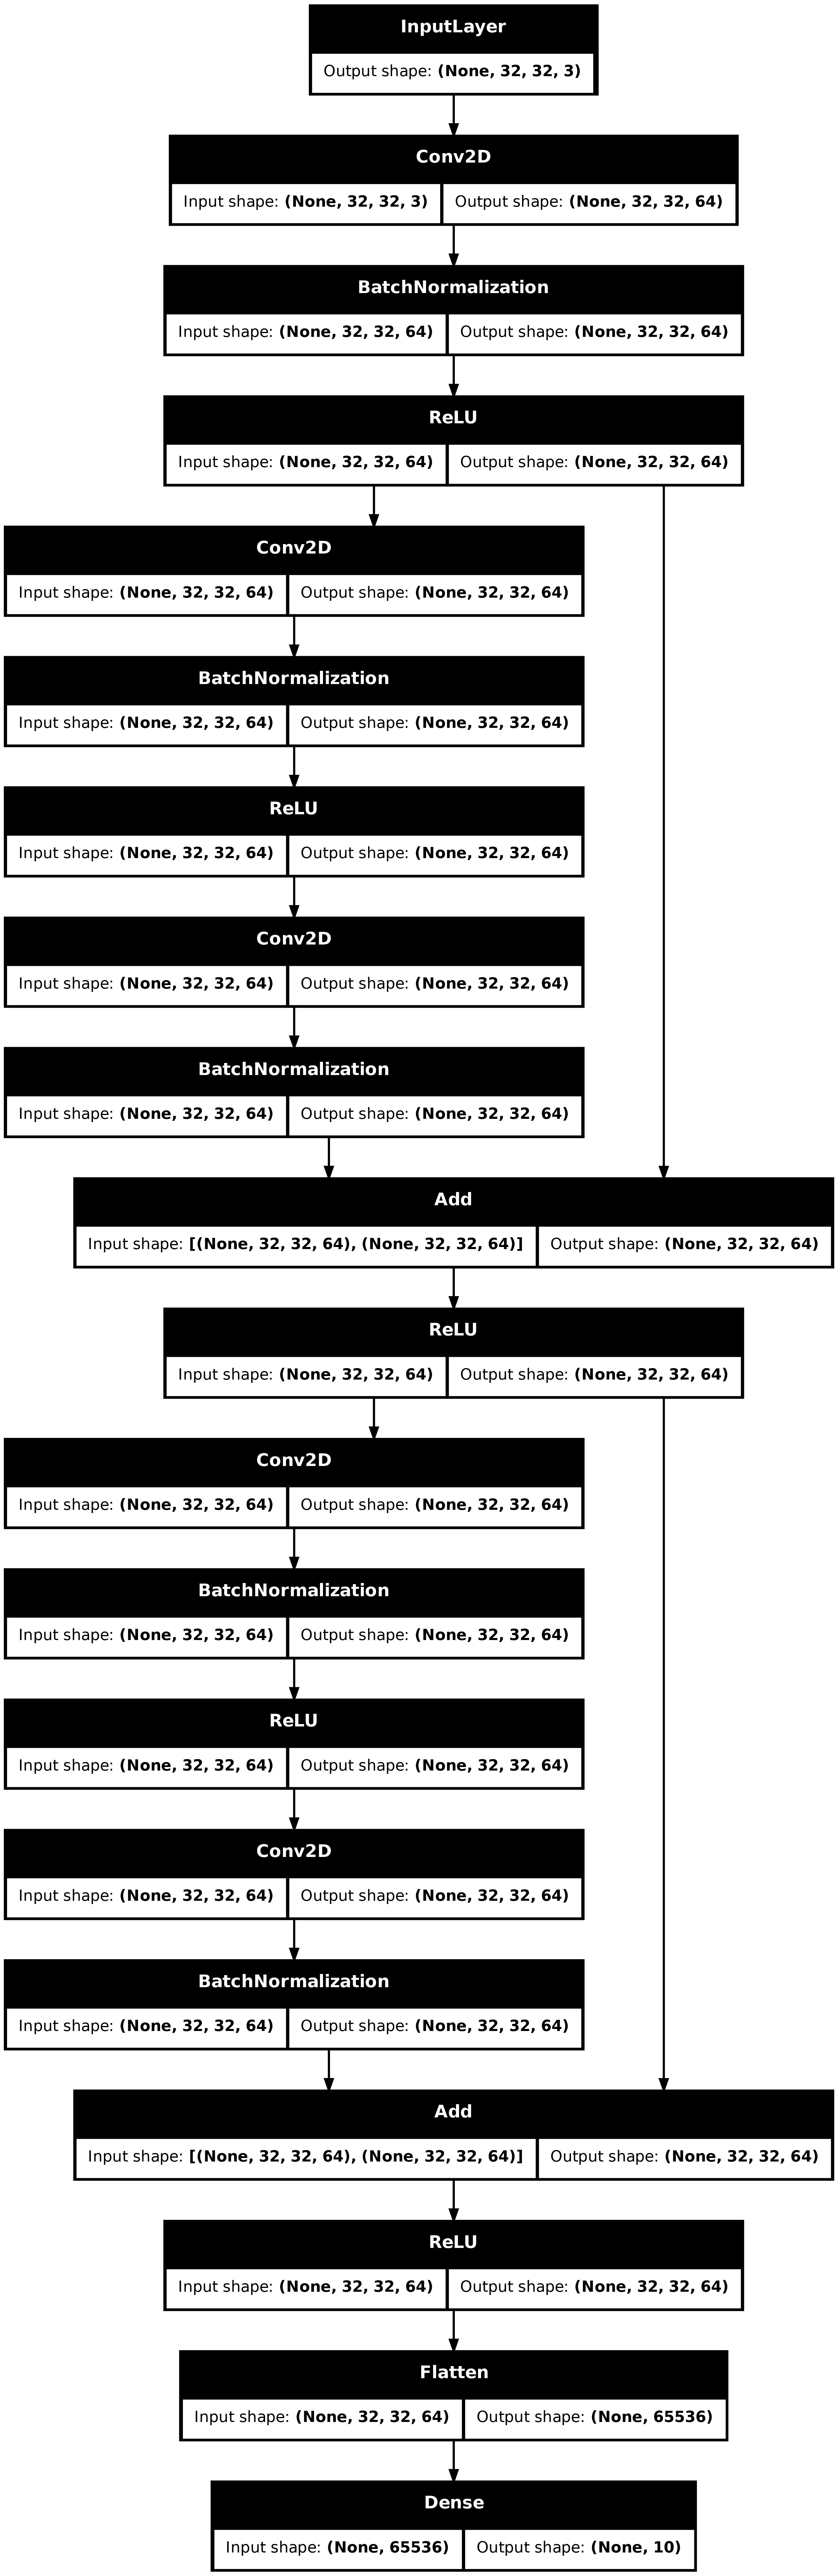

In [7]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

plot_model(
    model_resnet,
    # to_file="model.png",
    show_shapes=True,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=266,
    show_layer_activations=False,)

### ResNet 프리 트레인드 모델 이용하기

In [8]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

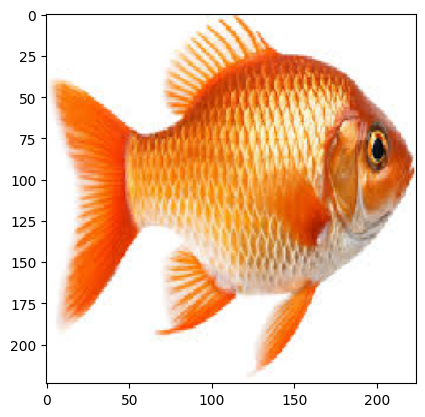

In [18]:
img = image.load_img('../../data/img_fish.png', target_size=(224, 224))
plt.imshow(img)
plt.show()

In [19]:
def classify(img_):
    img = img_
#     model = tf.keras.applications.resnet50.ResNet50()
    model = ResNet50(weights='imagenet', include_top=True) # this equals no weights parameter
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    prediction = model.predict(img_preprocessed)
    return decode_predictions(prediction, top=5)[0]

In [20]:
classify(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


[('n01443537', 'goldfish', 0.99899167),
 ('n02606052', 'rock_beauty', 0.0005714276),
 ('n01440764', 'tench', 6.654573e-05),
 ('n01496331', 'electric_ray', 4.417965e-05),
 ('n04286575', 'spotlight', 2.3862698e-05)]